In [3]:
# import all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gensim
from textblob import TextBlob
from tqdm import tqdm
from numpy import log, sqrt

import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

# Read files

In [4]:
air_bnb_ret_new = pd.read_csv('data/airbnb_ratings_new.csv',engine = 'python')

In [5]:
airbnb_reviews = pd.read_csv('data/airbnb_reviews.csv', delimiter=';', skiprows=0, low_memory=False)

### Dimension of each file (no preprocessing)

In [9]:
air_bnb_ret_new.shape

(1048575, 35)

In [10]:
airbnb_reviews.shape

(8348173, 6)

In [11]:
air_bnb_ret_new.head()

,Listing ID,Name,Host ID,Host Name,Host Response Rate,Host Is Superhost,Host total listings count,Street,City,Neighbourhood cleansed,...,Number of reviews,Last Review Date,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per month
0,13588243.0,Designer Urban Living - 2BR 1200sq,4386046.0,Chris,90%,False,3.0,Lau Li Street| 0| Hong Kong Island 0| Hong Kong,0,Wan Chai,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5534229.0,A 2 Passi da San Pietro,28697142.0,Veronica,100%,False,5.0,00165| Rm 00165| Italy,165,XIII Aurelia,...,2.0,8/29/15,90,9.0,10.0,8.0,8.0,9.0,9.0,0.08
2,18417052.0,Appartement pr�s m�tro Simonis,81453949.0,Kristina,100%,False,2.0,1081| Koekelberg 1081| Belgium,1081,Koekelberg,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5903406.0,cosy small apartment,1853799.0,Veronika,88%,False,2.0,1190| Wien| Austria,1190,D�bling,...,3.0,9/9/17,87,9.0,10.0,10.0,10.0,10.0,8.0,0.27
4,5203533.0,Rummelig lejl i hjertet af KBH,24801534.0,Marianne,100%,False,1.0,Indre By| 1366| Danmark K�benhavn K| Denmark,1366,Indre By,...,6.0,7/26/16,100,10.0,10.0,10.0,10.0,10.0,10.0,0.28


## Preprocessing

In [12]:
# Remove records with NAN
air_bnb_processed = air_bnb_ret_new.dropna()
air_bnb_processed.shape

(296074, 35)

In [13]:
# Calculating average score
air_bnb_processed['Average score'] = air_bnb_processed.iloc[:,-7:-1].sum(axis=1)/6

In [14]:
air_bnb_processed.head()

,Listing ID,Name,Host ID,Host Name,Host Response Rate,Host Is Superhost,Host total listings count,Street,City,Neighbourhood cleansed,...,Last Review Date,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per month,Average score
1,5534229.0,A 2 Passi da San Pietro,28697142.0,Veronica,100%,False,5.0,00165| Rm 00165| Italy,165,XIII Aurelia,...,8/29/15,90,9.0,10.0,8.0,8.0,9.0,9.0,0.08,8.833333
3,5903406.0,cosy small apartment,1853799.0,Veronika,88%,False,2.0,1190| Wien| Austria,1190,D�bling,...,9/9/17,87,9.0,10.0,10.0,10.0,10.0,8.0,0.27,9.500000
4,5203533.0,Rummelig lejl i hjertet af KBH,24801534.0,Marianne,100%,False,1.0,Indre By| 1366| Danmark K�benhavn K| Denmark,1366,Indre By,...,7/26/16,100,10.0,10.0,10.0,10.0,10.0,10.0,0.28,10.000000
6,8858475.0,Modern; spacious and warm; with its own balcony,3000397.0,Lasse,100%,True,1.0,2150| Danmark Nordhavn| Denmark,2150,sterbro,...,5/7/17,100,10.0,10.0,10.0,10.0,9.0,10.0,0.79,9.833333
7,4215511.0,Nice room; Bohemian Cph; N�rrebro,126020.0,Lea,100%,True,2.0,N�rrebro| 2200| K�benhavn N 2200| Denmark,2200,Nrrebro,...,5/8/17,94,10.0,10.0,9.0,10.0,10.0,10.0,1.40,9.833333


In [15]:
air_bnb_processed.describe()

,Listing ID,Host ID,Host total listings count,longitude,Accommodates,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,Number of reviews,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per month,Average score
count,2.960740e+05,2.960740e+05,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,2.960740e+05,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000,296074.000000
mean,1.008469e+07,3.315505e+07,8.168475,-21.865633,3.422452,1.240092,1.379246,125.087164,3.273796,2.499187e+05,191.742433,26.663287,9.541044,9.374795,9.693121,9.702615,9.476371,9.331218,1.835202,9.519860
std,5.894666e+06,3.447327e+07,45.383561,72.133065,2.131286,0.574650,0.891551,122.450854,112.900565,2.180742e+07,130.752311,39.675861,0.890414,1.014010,0.812745,0.798468,0.873761,0.955951,1.854571,0.721294
min,6.000000e+00,1.900000e+01,0.000000,-124.419116,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.886716e+06,6.258748e+06,1.000000,-79.182359,2.000000,1.000000,1.000000,56.000000,1.000000,3.200000e+01,64.000000,4.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.520000,9.333333
50%,1.035579e+07,2.079027e+07,1.000000,-0.111220,3.000000,1.000000,1.000000,90.000000,2.000000,1.125000e+03,200.000000,12.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.180000,9.666667
75%,1.524822e+07,4.884093e+07,3.000000,4.939786,4.000000,1.000000,2.000000,149.000000,3.000000,1.125000e+03,321.000000,32.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.590000,10.000000
max,2.199041e+07,1.598461e+08,1026.000000,153.637837,20.000000,15.500000,14.000000,999.000000,60000.000000,2.147484e+09,365.000000,735.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,90.000000,10.000000


In [16]:
#Remove rows with all rating = 0
air_bnb_processed = air_bnb_processed[air_bnb_processed['Average score'] > 0]
air_bnb_processed.shape

(295626, 36)

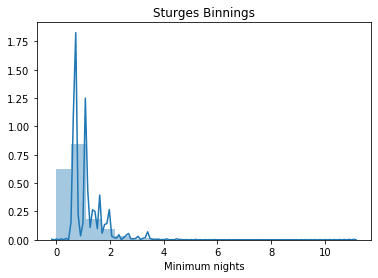

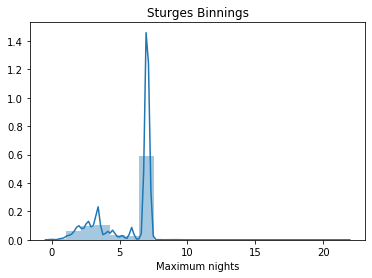

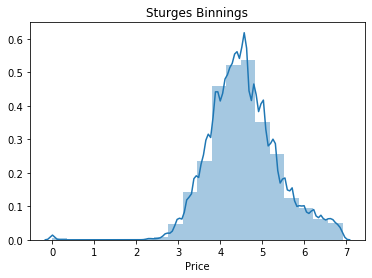

In [17]:
N = len(air_bnb_ret_new)

def rice(x):
    return int(2 * x ** (1/3))
    
def logify(x):
    return log(x) if x else 0

def sturges(x):
    from numpy import log2
    return int(log2(x)) + 1

fig1 = sns.distplot(air_bnb_ret_new['Minimum nights'].apply(logify), bins=sturges(N))
plt.title("Sturges Binnings")
plt.show()

fig1 = sns.distplot(air_bnb_ret_new['Maximum nights'].apply(logify), bins=sturges(N))
plt.title("Sturges Binnings")
plt.show()

fig1 = sns.distplot(air_bnb_ret_new['Price'].apply(logify), bins=sturges(N))
plt.title("Sturges Binnings")
plt.show()

In [18]:
# Outliers can be detected in some features
# Remove detected outliers
air_bnb_processed=air_bnb_processed.loc[(2 <= air_bnb_processed.Price) 
                                       &(air_bnb_processed.Price <= 256) 
                                       &(air_bnb_processed.Bedrooms) != 0
                                       &(1 <= air_bnb_processed['Minimum nights'])
                                       &(1 <= air_bnb_processed['Maximum nights'])
                                       &(air_bnb_processed['Minimum nights'] <= 64)
                                       &(air_bnb_processed['Maximum nights'] <= 128)]

In [19]:
air_bnb_processed.shape

(251574, 36)

## Correlation

Text(0.5, 1, 'Correlation Matrix')

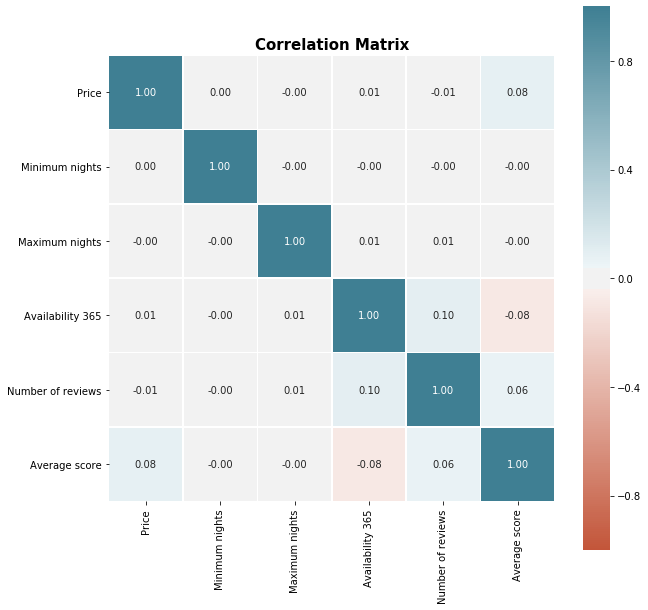

In [21]:
plt.figure(figsize=(10,10))
palette = sns.diverging_palette(20, 220, n=256)
corr = air_bnb_processed[["Price", "Minimum nights", "Maximum nights", "Availability 365", "Number of reviews", "Average score"]].corr(method='pearson')
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, center=0, square=True, vmax=1, vmin=-1, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Correlation Matrix",size=15, weight='bold')

# Read review dataset after vectorized

In [22]:
airbnb_reviews_en_doc2vec50 = pd.read_feather('data/airbnb_reviews_en_doc2vec50.feather').drop("index", axis = 1)

In [23]:
airbnb_reviews_en_doc2vec50.head()

,listing_id,id,date,reviewer_id,reviewer_name,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,488835,104522929,2016-09-27,66003975,Carole,0.036508,0.009067,0.223529,-0.347406,0.100138,...,0.030112,0.079126,-0.225693,-0.246019,-0.064386,-0.077692,-0.356109,0.028490,-0.328283,-0.069555
1,549036,45480519,2015-09-03,38589960,Ewelina,-0.192816,0.153045,0.139764,-0.178359,0.038831,...,0.038653,0.021658,-0.070389,-0.354855,-0.233599,-0.070197,-0.463740,-0.135979,-0.124472,-0.318148
2,13546118,137928884,2017-03-18,111268477,Donovan,-0.030356,0.078700,0.083783,-0.148704,0.006974,...,0.028900,-0.028756,-0.033886,-0.201330,-0.114471,-0.019784,-0.266979,0.014943,-0.070331,-0.087621
3,549036,78711836,2016-06-08,25834,Armen,-0.171718,0.084452,0.269192,-0.285912,0.136310,...,0.175035,0.134480,0.167962,-0.207885,0.029879,0.016864,-0.151559,-0.048305,-0.355937,-0.133211
4,2643611,84818807,2016-07-09,72772795,Rebecca,-0.146144,0.123450,0.206628,-0.244288,0.215355,...,-0.091308,-0.020278,0.034141,-0.354655,0.061096,-0.107102,-0.295958,-0.016903,-0.267805,-0.059945


In [24]:
airbnb_reviews_en_doc2vec50.shape

(6819303, 55)

### Convert Lising ID into same format

In [25]:
air_bnb_processed["Listing ID"] = air_bnb_processed["Listing ID"].apply(lambda x: int(x))

### Calculate sentiment score

In [12]:
airbnb_reviews_en = pd.read_feather("data/airbnb_reviews_en_sentiment.feather")

In [13]:
airbnb_reviews_en.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Sentiment
0,488835,104522929,2016-09-27,66003975,Carole,First time using Airbnb and couldn't be happie...,0.610938
1,549036,45480519,2015-09-03,38589960,Ewelina,I had really good time in Alex apartment and I...,0.583333
2,13546118,137928884,2017-03-18,111268477,Donovan,Place is pretty nice and Sergio was a big help...,0.337500
3,549036,78711836,2016-06-08,25834,Armen,We enjoyed our trip to Barcelona and partially...,0.333411
4,2643611,84818807,2016-07-09,72772795,Rebecca,Patrica was the perfect host. She meet us at t...,0.590000


In [60]:
from tqdm import tqdm 
tqdm.pandas(desc='pandas bar')
airbnb_reviews_en["Sentiment"] = airbnb_reviews_en["comments"].progress_apply(lambda x: TextBlob(x).sentiment[0])

pandas bar: 100%|██████████| 6819303/6819303 [1:01:40<00:00, 1842.72it/s]


In [91]:
airbnb_reviews_en.loc[airbnb_reviews_en.Sentiment > 0]

,listing_id,id,date,reviewer_id,reviewer_name,comments,Sentiment
0,488835,104522929,2016-09-27,66003975,Carole,First time using Airbnb and couldn't be happie...,0.610938
1,549036,45480519,2015-09-03,38589960,Ewelina,I had really good time in Alex apartment and I...,0.583333
2,13546118,137928884,2017-03-18,111268477,Donovan,Place is pretty nice and Sergio was a big help...,0.337500
3,549036,78711836,2016-06-08,25834,Armen,We enjoyed our trip to Barcelona and partially...,0.333411
4,2643611,84818807,2016-07-09,72772795,Rebecca,Patrica was the perfect host. She meet us at t...,0.590000
...,...,...,...,...,...,...,...
6819298,3102110,135630339,2017-03-05,112572493,Jordan,Super cute place! James and Yuna let us check ...,0.327083
6819299,3102110,136124314,2017-03-08,92004669,Diane,Great place. Great hosts.,0.800000
6819300,3102110,137148950,2017-03-13,48886823,Jessica,Everything they said was true! It's a nice pla...,0.407500
6819301,3102110,144335011,2017-04-15,66082823,Isabel,James and Yuna's place was awesome. They where...,0.400000


### Read dataset that combines reviews from same Airbnb

In [11]:
airbnb_reviews_en_join = pd.read_feather("data/airbnb_reviews_en_join.feather").drop('index', axis = 1)

In [16]:
from tqdm import tqdm 
tqdm.pandas(desc='Bar')
airbnb_reviews_en_join["Sentiment"] = airbnb_reviews_en_join["comments"].progress_apply(lambda x: TextBlob(x).sentiment[0])

Bar: 100%|██████████| 359873/359873 [1:05:35<00:00, 91.44it/s]  


In [22]:
doc2vec50 = pd.read_feather("data/airbnb_reviews_en_join_doc2vec50.feather").drop("index", axis = 1)

In [28]:
doc2vec50["Sentiment"] = airbnb_reviews_en_join.Sentiment

In [34]:
df_merge = pd.merge(doc2vec50, air_bnb_processed, left_on='listing_id', right_on='Listing ID').drop('Listing ID',axis=1)

In [36]:
df_final = df_merge[[str(i) for i in range(50)] + ["Sentiment", "Average score"]]

### Export feather for modelling

In [41]:
df_final.to_feather("df_final.feather")